In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed 
from numba import jit

import scipy.linalg
from sklearn import linear_model
import sklearn.linear_model as skl
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

In [2]:
# Define the Franke Fumction
def frankeFunction(x1,x2,sig2):
    noise = np.random.normal(0,sig2,x1.shape)
    term1 = 0.75*np.exp(-(0.25*(9*x1-2)**2) - 0.25*((9*x2-2)**2))
    term2 = 0.75*np.exp(-((9*x1+1)**2)/49.0 - 0.1*(9*x2+1))
    term3 = 0.5*np.exp(-(9*x1-7)**2/4.0 - 0.25*((9*x2-3)**2))
    term4 = -0.2*np.exp(-(9*x1-4)**2 - (9*x2-7)**2)
    return term1 + term2 + term3 + term4 + noise

# Create the data points in mesh grid form
def createDataPoints(n, sig2):
    x1 = np.arange(0, 1, 1/n)
    x2 = np.arange(0, 1, 1/n)
#     x1 = np.sort(np.random.uniform(0, 5, n))
#     x2 = np.sort(np.random.uniform(0, 5, n))
    x1_d, x2_d = np.meshgrid(x1,x2)
    y_d = frankeFunction(x1_d,x2_d,sig2)
    return x1_d, x2_d, y_d.ravel()

# Create the design matrix with all possible combinations
@jit
def createDesignMatrix(x1, x2, n):
    if len(x1.shape) > 1:
        x1 = np.ravel(x1)
        x2 = np.ravel(x2)

    N = len(x1)
    p = int((n+1)*(n+2)/2)
    X = np.ones((N,p))

    for i in range(1, n+1):
        q = int(i*(i+1)/2)
        for j in range(i+1):
            X[:,q+j] = (x1**(i-j))*(x2**j)
    return X

# Predict the outcome using matrix inversion
def predict(X, y_data):
    beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y_data)
    y_tilde = X @ beta
    return y_tilde, beta

# Calculate the mean square error (MSE)
def MSE(y_data, y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# Calculate the coefficient of determination (R2)
def R2(y_data, y_model):
    n = np.size(y_data)
    return 1 - np.sum((y_data-y_model)**2)/np.sum((y_data-(np.sum(y_data)/n))**2)

#Scale the data and split them for training and testing
def Scale(X_train, X_test):
    XX = np.copy(X_test)
    if X_train.shape[1] > 1:
        scaler = StandardScaler()
        scaler.fit(X_train[:,1:])
        X_train[:,1:] = scaler.transform(X_train[:,1:])
        XX[:,1:] = scaler.transform(XX[:,1:])  
    return X_train, XX#, y_train[:, np.newaxis], y_test[:, np.newaxis]

# Calculate the confidence interval of parameters Beta's
def CIBeta(X, Beta):
    varBeta = np.diagonal(np.linalg.pinv(X.T @ X)*sig2)
#     print(((X.T @ X)))
    print(varBeta.shape)
    print(Beta.shape)
    stdBeta = np.sqrt(varBeta)
    errorBeta = 1.645*stdBeta
    return errorBeta

# I cannot get this function to work with X_train
def SVDinv(A):
    U, s, VT = np.linalg.svd(A)
    print(A.shape)
    print(U.shape)
    print(s.shape)
    print(VT.shape)
    S = np.diag(s)
    UT = np.transpose(U)
    V = np.transpose(VT)
    invS = np.linalg.inv(S)
    #print(np.matmul(V,np.matmul(invD,UT)).shape)
    return np.matmul(V,np.matmul(invS,UT))

def kfoldCV(x,y,z,k=5):
    # The general procedure is as follows:
    # 1. Shuffle the dataset randomly.
    # 2. Split the dataset into k groups
    # 3. For each unique group:
    #    1. Take the group as a hold out or test data set
    #    2. Take the remaining groups as a training data set
    #    3. Fit a model on the training set and evaluate it on the test set
    #    4. Retain the evaluation score and discard the model
    # 4. Summarize the skill of the model using the sample of model evaluation scores
    
    #Concatenate the data points
    #data = np.concatenate((x,y),axis=0)
    
    #HOW TO COMBINE X AND Y IN THE RIGHT FORMAT?
    #First, split data into test and training set
    x_train, x_test, y_train, y_test = train_test_split(data,y,test_size=0.3)
    
    data = np.concatenate((x_train, y_train), axis=1)
    
    #Randomly shuffle the data
    np.random.shuffle(data)
    
    #Split data set into k parts
    splitData = np.array_split(data,k)
    
    for i in range(0,k):
        train = np.zeros((0,3)) #reset train set for each kth run
        for j in range(0,k):
            if j==i:
                test = splitData[j]
                continue
            train = np.concatenate((train, splitData[j]), axis=0)
        
        X_design = createDesignMatrix(train[:,0], train[:,1])
    

def ridgeRegression(X_train,X_test,y_train,n):   
    N = np.size(X_train,1)
    I = np.eye(N)
    
    # Decide which value of lambda to use
    nlambdas = 4
    MSEPredict = np.zeros(nlambdas)
    MSETrain = np.zeros(nlambdas)
    MSEPredictSKL = np.zeros(nlambdas)
    lambdas = np.logspace(-4,1, nlambdas)
    for i in range(nlambdas):
        lmb = lambdas[i]
        # Add Ridge
        clf_ridge = skl.Ridge(alpha=lmb).fit(X_train,y_train)
        beta_ridge = np.linalg.inv(X_train.T @ X_train + lmb*I) @ X_train.T @ y_train
        # Make predictions
        y_tilde = X_train @ beta_ridge
        y_predict = X_test @ beta_ridge
        y_ridgeSKL = clf_ridge.predict(X_test)
        MSEPredict[i] = MSE(y_test, y_predict)
        MSETrain[i] = MSE(y_train, y_tilde)
        MSEPredictSKL[i] = MSE(y_test, y_ridgeSKL)
    plt.figure()
    plt.plot(np.log10(lambdas), MSETrain, label = 'MSE Ridge train')
    plt.plot(np.log10(lambdas), MSEPredict, 'r--', label = 'MSE Ridge Test')
    plt.plot(np.log10(lambdas), MSEPredictSKL, 'g--', label = 'MSE Ridge sickit-learn Test')
    plt.xlabel('log10(lambda)')
    plt.ylabel('MSE')
    plt.legend()
    plt.title(f'Lambda = {nlambdas}')

def lassoRegression():
    # Use the Scikit-learn functionality
    pass


    
    


a) OLS

The R2 value for a polynomial of order 4, OLS test: 0.473540624964245
The MSE value for a polynomial of order 4, OLS test: 0.03377714380979957

The R2 value for a polynomial of order 4, OLS train: 0.8886270157487366
The MSE value for a polynomial of order 4, OLS train: 0.011312894649009699
(15,)
(15,)

The 90% confidence interval for beta_2 is -0.11124173482257671 ⟷ 3.0382324405700936


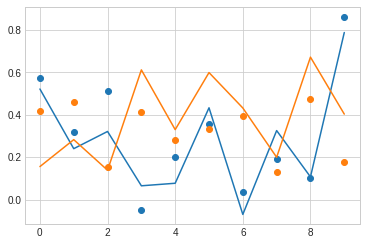

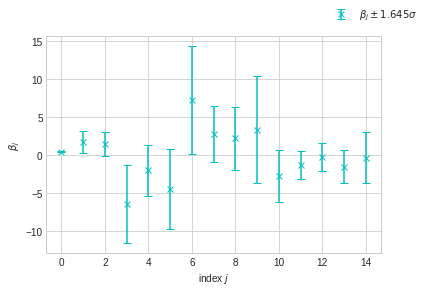

In [54]:
# np.random.seed(2020)

sig2 = 0.1 # noise variance
degree = 4 # polynomial degree
n = 10 # number of data points for each feature
x1, x2, y = createDataPoints(n, sig2)
X = createDesignMatrix(x1,x2,degree)
# print(X.shape)
# print(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
X_train, X_test = Scale(X_train, X_test)

beta = np.linalg.pinv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
y_tilde = (X_train @ beta)
y_pred = (X_test @ beta)


plt.figure(0)
# plt.plot(X_train[:, 1], y_tilde, label="y_tilde")
plt.plot(y_tilde[:10], label="y_tilde")
plt.scatter(np.arange(10), y_train[:10], label="y_train")

plt.plot(y_pred[:10], label="y_pred")
plt.scatter(np.arange(10), y_test[:10], label="y_test")
# plt.plot(y_pred, label="y_pred")
# plt.scatter(X_train[:, 1], y_tilde)

print(f"The R2 value for a polynomial of order {degree}, OLS test: {R2(y_test, y_pred)}")
print(f"The MSE value for a polynomial of order {degree}, OLS test: {MSE(y_test, y_pred)}")
print(f"\nThe R2 value for a polynomial of order {degree}, OLS train: {R2(y_train, y_tilde)}")
print(f"The MSE value for a polynomial of order {degree}, OLS train: {MSE(y_train, y_tilde)}")

# Calculate the confidence interval of the 'p' parameters beta
errorBeta = CIBeta(X_train, beta)

# Print an example of a confidence interval
print(f"\nThe 90% confidence interval for beta_2 is {beta[2]-errorBeta[2]} ⟷ {beta[2]+errorBeta[2]}")

# Plot the Confidence Intervals for the betas
ax2 = plt.figure(1)
plt.errorbar(np.arange(len(beta)), beta, errorBeta, fmt='cx', capsize=4, label=r"$\beta_j \pm 1.645 \sigma$")
plt.xlabel("index $j$")
plt.ylabel(r"$\beta_j $")
ax2.legend(facecolor='white', framealpha=1, loc='upper right')

b)

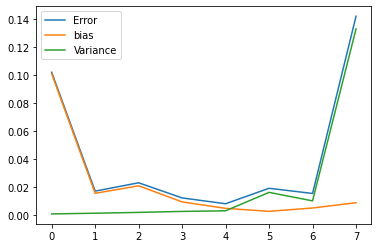

In [400]:
# np.random.seed(20)
# print(np.random.get_state()[1][0])

sig2 = 0#.001 # noise variance
n = 10 # number of data points for each feature
n_boostraps = 100 # number of bootstraps 
maxdegree = 8 # maximum polynomial degree

for n in range(10,11):
#     print(n)
    # Make data set.
    x1, x2, y = createDataPoints(n, sig2)
    x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)
#     print(x.shape)

    # Define empty arrays
    error = np.zeros(maxdegree)
    bias = np.zeros(maxdegree)
    variance = np.zeros(maxdegree)
    polydegree = np.zeros(maxdegree)


    for degree in range(maxdegree):
#         print("\n", degree, "\n")
        X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  
        
        # Split and scale the design data
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
        y_train, y_test = y_train[:, np.newaxis], y_test[:, np.newaxis]
#         X_test.flags.writeable = False
        y_pred = np.empty((y_test.shape[0], n_boostraps))
        for i in range(n_boostraps):
#             print(i)
            x_, y_ = resample(X_train, y_train)
#             print("X_test before", X_test[:1, :])

            x_, X_test2 = Scale(x_, X_test)
#             print("X_test after", X_test2[:1, :])

            beta = np.linalg.pinv(x_.T.dot(x_)).dot(x_.T).dot(y_)
            y_pred[:, i] = (X_test2 @ beta).squeeze()

        polydegree[degree] = degree
        error[degree] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
        bias[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
        variance[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True) )
#         print("Polynomial degree:", degree)
#         print("Error:", error[degree])
#         print("Bias^2:", bias[degree])
#         print("Var:", variance[degree])
#         print('{} >= {} + {} = {}\n'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))
#         break
    plt.plot(polydegree, error, label="Error")
    plt.plot(polydegree, bias, label="bias")
    plt.plot(polydegree, variance, label="Variance")
    plt.legend()
    plt.show()

c)

In [5]:
np.random.seed(20)

sig2 = 1 # noise variance
n = 10 # number of data points for each feature
k = 5
degree = 5

x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)
# y = y.ravel()

X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  
print(X.shape)
print(y.shape)
p = np.random.permutation(X.shape[0])
X = X[p]
y = y[p]

# y_pred = np.empty((np.int(X.shape[0]/k), k))

#Split data set into k parts
splitXData = np.array(np.split(X,k))
splitYData = np.array(np.split(y,k))
print("All X data split", splitXData.shape)
print("All y data split", splitYData.shape)

MSErrors = np.zeros(k)

for i in range(0,k):
    mask = np.ones(k)
    mask[i]=0
    X_train = splitXData[mask==1].reshape(((splitXData.shape[0]-1)*splitXData.shape[1],-1))
    X_test = splitXData[mask==0].squeeze()

    y_train = splitYData[mask==1].reshape(((splitYData.shape[0]-1)*splitXData.shape[1],1))
    y_test = np.swapaxes(splitYData[mask==0], 0, 1)

    beta = np.linalg.pinv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
    y_pred = (X_test @ beta).squeeze()

    MSErrors[i] = np.mean((y_test - y_pred)**2, keepdims=True)
    
MSError = np.mean(MSErrors)
# bias[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
# variance[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True) ) 

print("Polynomial degree:", degree)
print("MSE:", MSError)
# print("Bias^2:", bias[degree])
# print("Var:", variance[degree])
# print('{} >= {} + {} = {}\n'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))


(100, 21)
(100,)
All X data split (5, 20, 21)
All y data split (5, 20)
Polynomial degree: 5
MSE: 1.864751041971474


d)

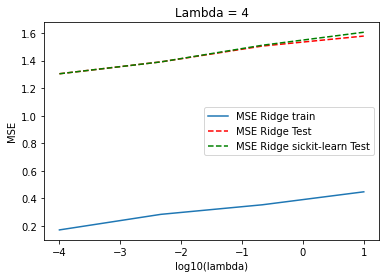

In [84]:
ridgeRegression(X_train, X_test,z_train,n)